In [ ]:
%pip install numpy matplotlib openvino-dev

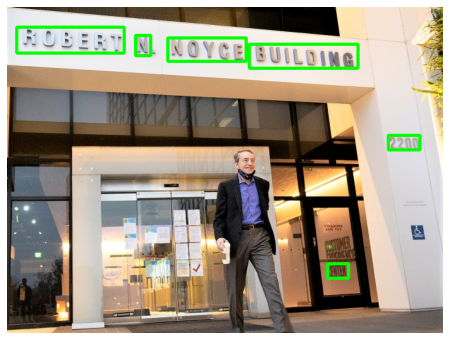

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from openvino.runtime import Core

# For each detection, the description is in the [x_min, y_min, x_max, y_max, conf] format:
# The image passed here is in BGR format with changed width and height. To display it in colors expected by matplotlib, use cvtColor function
def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.3, conf_labels=True):
    # Define colors for boxes and descriptions.
    colors = {"red": (255, 0, 0), "green": (0, 255, 0)}

    # Fetch the image shapes to calculate a ratio.
    (real_y, real_x), (resized_y, resized_x) = bgr_image.shape[:2], resized_image.shape[:2]
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Convert the base image from BGR to RGB format.
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Iterate through non-zero boxes.
    for box in boxes:
        # Pick a confidence factor from the last place in an array.
        conf = box[-1]
        if conf > threshold:
            # Convert float to int and multiply corner position of each box by x and y ratio.
            # If the bounding box is found at the top of the image,
            # position the upper box bar little lower to make it visible on the image.
            (x_min, y_min, x_max, y_max) = [
                int(max(corner_position * ratio_y, 10)) if idx % 2
                else int(corner_position * ratio_x)
                for idx, corner_position in enumerate(box[:-1])
            ]

            # Draw a box based on the position, parameters in rectangle function are: image, start_point, end_point, color, thickness.
            rgb_image = cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 3)

            # Add text to the image based on position and confidence.
            # Parameters in text function are: image, text, bottom-left_corner_textfield, font, font_scale, color, thickness, line_type.
            if conf_labels:
                rgb_image = cv2.putText(
                    rgb_image,
                    f"{conf:.2f}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image

ie = Core()

model = ie.read_model(model="models/public/horizontal-text-detection-0001/FP16-INT8/horizontal-text-detection-0001.xml")
compiled_model = ie.compile_model(model=model, device_name="AUTO")
input_layer_ir = compiled_model.input(0)
output_layer_ir = compiled_model.output("boxes")

# Read BGR image
image = cv2.imread("data/intel_rnb.jpg")
# Get input shape: batch, channels, height, width
N, C, H, W = input_layer_ir.shape
# Resize image to input shape
resized_image = cv2.resize(src=image, dsize=(W, H))
# Reshape image to input shape
# H, W, C -> 0, C, H, W
input_image = np.expand_dims(resized_image.transpose(2,0,1), axis=0)

#plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#plt.show()

# Run inference
boxes = compiled_model([input_image])[output_layer_ir]
# Remove zero boxes
boxes = boxes[~np.all(boxes == 0, axis=1)]

plt.figure(figsize=(10, 6))
plt.axis("off")
plt.imshow(convert_result_to_image(image, resized_image, boxes, conf_labels=False));
plt.show()
